### North-South photometry

The purpose of this notebook is to explore the differences in the observed and synthesized photometry in the overlap region between the (north) BASS+MzLS and (south) DECaLS photometric catalogs.

Before running this notebook, you have to run 

John Moustakas  
Siena College  
April 2024

In [54]:
import os
import numpy as np
import fitsio
from glob import glob
import corner as cn
from astropy.table import Table, join
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

sns.set(context='talk', style='whitegrid', font_scale=0.8)
colors = sns.color_palette()

%matplotlib inline

### Read the data

In [62]:
def read_phot():
    metafile = '/global/cfs/cdirs/desicollab/users/ioannis/fastspecfit/northsouth/metadata-iron-main-bright.fits'
    northfile = '/global/cfs/cdirs/desicollab/users/ioannis/fastspecfit/northsouth/tractor-iron-main-bright-north.fits'
    southfile = '/global/cfs/cdirs/desicollab/users/ioannis/fastspecfit/northsouth/tractor-iron-main-bright-south.fits'
    meta = Table(fitsio.read(metafile))
    north = Table(fitsio.read(northfile))
    south = Table(fitsio.read(southfile))
    
    #I = ((north['FLUX_G'] > 0.) * (north['FLUX_R'] > 0.) * (north['FLUX_Z'] > 0.) * 
    # (south['FLUX_G'] > 0.) * (south['FLUX_R'] > 0.) * (south['FLUX_Z'] > 0.))
    #north = north[I]
    #south = south[I]
    #meta = meta[I]
    
    return meta, north, south

In [63]:
%time meta, north, south = read_phot()

CPU times: user 933 ms, sys: 412 ms, total: 1.35 s
Wall time: 1.36 s


### Make some plots

In [64]:
def cplot(x, y, lim, ccol=colors[1], levels=[0.5, 0.75, 0.95, 0.99], smooth=1.5):
    contour_kwargs = {'colors': 'k', 'alpha': 0.8, 'linewidths': 1}
    data_kwargs = {'color': ccol, 'alpha': 0.5, 'ms': 2}

    fig, ax = plt.subplots()
    _ = cn.hist2d(x, y, range=[lim, lim], bins=100, color=ccol, 
                  smooth=smooth, levels=levels, contour_kwargs=contour_kwargs,
                  data_kwargs=data_kwargs, ax=ax)
    ax.plot(lim, lim, color='k')

In [65]:
def getmag(cat, band):
    return 22.5 -2.5 * np.log10(cat[f'FLUX_{band.upper()}'].data)

def getcolor(cat, band1, band2):
    return -2.5 * np.log10(cat[f'FLUX_{band1.upper()}'].data / cat[f'FLUX_{band2.upper()}'].data)

In [66]:
nr = getmag(north, 'r')
sr = getmag(south, 'r')
ng = getmag(north, 'g')
sg = getmag(south, 'g')
ngr = getcolor(north, 'g', 'r')
sgr = getcolor(south, 'g', 'r')

In [67]:
glim = (17, 22.5)
rlim = (16, 21)
grlim = (-0.2, 2.1)

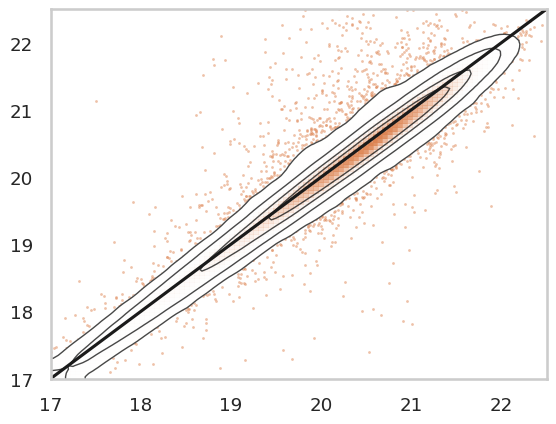

In [68]:
cplot(ng, sg, glim)

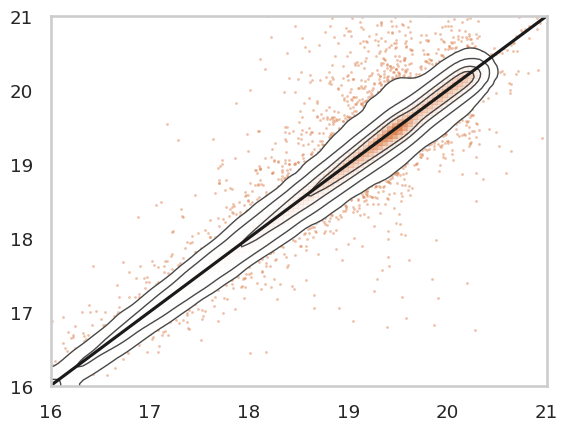

In [69]:
cplot(nr, sr, rlim)

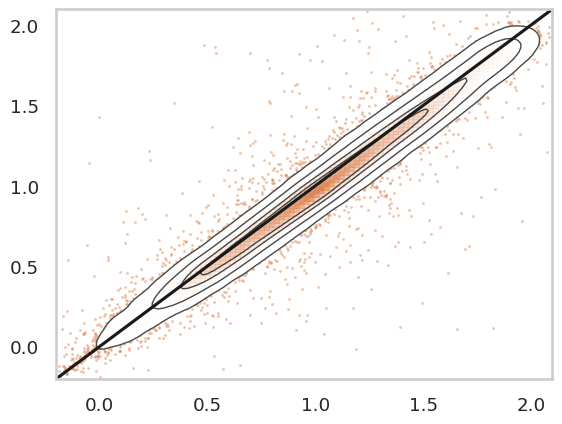

In [70]:
cplot(ngr, sgr, grlim)

In [ ]:
stop

In [86]:
nn = Table(fitsio.read('/global/cfs/cdirs/desicollab/users/ioannis/fastspecfit/northsouth/north/iron/catalogs/fastphot-iron-north.fits', 'FASTPHOT'))
ss = Table(fitsio.read('/global/cfs/cdirs/desicollab/users/ioannis/fastspecfit/northsouth/south/iron/catalogs/fastphot-iron-south.fits', 'FASTPHOT'))
mnn = Table(fitsio.read('/global/cfs/cdirs/desicollab/users/ioannis/fastspecfit/northsouth/north/iron/catalogs/fastphot-iron-north.fits', 'METADATA'))
mss = Table(fitsio.read('/global/cfs/cdirs/desicollab/users/ioannis/fastspecfit/northsouth/south/iron/catalogs/fastphot-iron-south.fits', 'METADATA'))

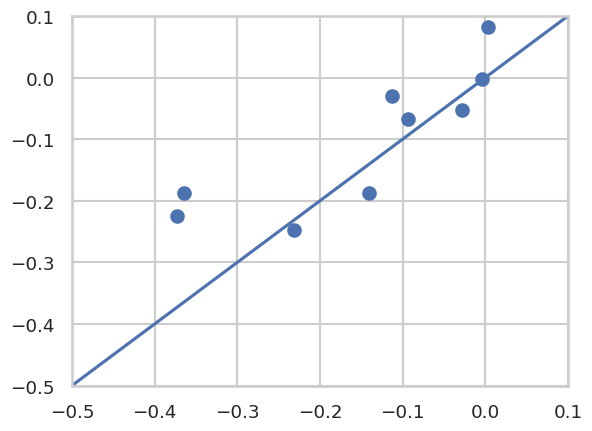

In [91]:
xx = -2.5 * np.log10(mnn['FLUX_R'].data / nn['FLUX_SYNTH_PHOTMODEL_R'].data)
yy = -2.5 * np.log10(mss['FLUX_R'].data / ss['FLUX_SYNTH_PHOTMODEL_R'].data)
plt.scatter(xx, yy)
plt.xlim(-0.5, 0.1)
plt.ylim(-0.5, 0.1)
plt.plot([-0.5, 0.1], [-0.5, 0.1])

In [3]:
fastfile = '/global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v2.1/catalogs/fastspec-iron-main-bright.fits'
#%time fast = Table(fitsio.read(fastfile, 'FASTSPEC'))
%time meta = Table(fitsio.read(fastfile, 'METADATA', columns=['TARGETID', 'PHOTSYS', 'RA', 'DEC']))

CPU times: user 992 ms, sys: 1.17 s, total: 2.16 s
Wall time: 2.85 s


#### Objects in the North/South overlap regions

See Table 2 in Dey et al. 2019.

In [43]:
I1 = (meta['RA'] > 100.) * (meta['RA'] < 280.) * (meta['DEC'] > 32.5) * (meta['DEC'] < 34.5)
I2 = (meta['RA'] > 36.) * (meta['RA'] < 42.) * (meta['DEC'] > -1.3) * (meta['DEC'] < 1.3)
I3 = (meta['RA'] > 350.) * (meta['DEC'] > -1.3) * (meta['DEC'] < 1.3)
I4 = (meta['RA'] < 10.) * (meta['DEC'] > -1.3) * (meta['DEC'] < 1.3)
I5 = (meta['RA'] > 317.) * (meta['RA'] < 330.) * (meta['DEC'] > -1.3) * (meta['DEC'] < 1.3)
I6 = (meta['RA'] > 330.) * (meta['RA'] < 336.) * (meta['DEC'] > -1.3) * (meta['DEC'] < 1.3)
I = np.logical_or.reduce((I1, I2, I3, I4, I5, I6))
meta[I]

TARGETID,RA,DEC,PHOTSYS
int64,float64,float64,str1
2377104985423872,260.2651,33.738,S
2389495336927235,36.97719719995529,-1.2895913191206643,S
2389495383064577,39.61556537380766,-1.1340770303471135,S
2389500072296449,319.03921685344886,-1.2603563468596384,S
2389500076490753,319.30752477635417,-1.1384586443894862,S
2389500084879360,319.92125206158187,-1.261638404554001,S
2389500311371776,333.4968574529299,-1.1871584218434876,S
2389500802105346,2.5235593560903706,-1.0960582278609983,S
2389501364142086,36.2217408350759,-1.0065338392558252,S


In [32]:
N = I * (meta['PHOTSYS'] == 'N')
S = I * (meta['PHOTSYS'] == 'S')

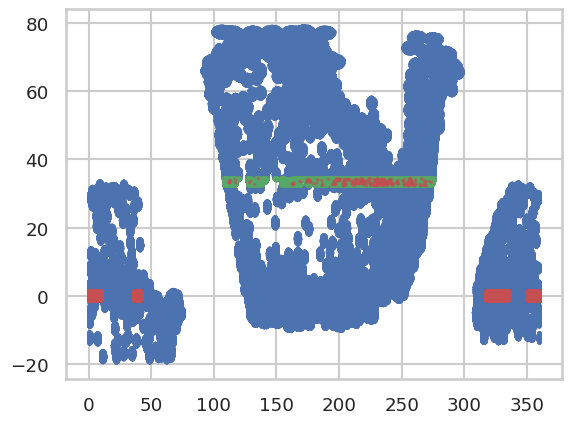

In [34]:
plt.scatter(meta['RA'], meta['DEC'], s=1)
plt.scatter(meta['RA'][I], meta['DEC'][I], s=1)
plt.scatter(meta['RA'][N], meta['DEC'][N], s=1)
plt.scatter(meta['RA'][S], meta['DEC'][S], s=1, alpha=0.5)
#plt.xlim(210, 225)#260)
#plt.ylim(30, 40)

In [ ]:
from desitarget.cuts import select_targets
select_targets()
    
```python
select_targets 
/global/cfs/cdirs/desicollab/users/ioannis/fastspecfit/northsouth
```

#### Read the sweep files

In [39]:
nsweepfiles = np.array(glob('/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/north/sweep/9.0/sweep-*.fits'))
ssweepfiles = np.array(glob('/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/south/sweep/9.0/sweep-*.fits'))

In [36]:
def parse_sweepfiles(sweepfiles):
    ramins, ramaxs, decmins, decmaxs = [], [], [], []
    for sweepfile in sweepfiles:
        sweep = os.path.basename(sweepfile).split('-')
        mn = sweep[1]
        mx = sweep[2].replace('.fits', '')
        if 'p' in mn:
            ramin, decmin = mn.split('p')
            decmin = float(decmin)
        elif 'm' in mn:
            ramin, decmin = mn.split('m')
            decmin = - float(decmin)
        ramin = float(ramin)
            
        if 'p' in mx:
            ramax, decmax = mx.split('p')
            decmax = float(decmax)
        elif 'm' in mx:
            ramax, decmax = mx.split('m')
            decmax = - float(decmax)
        ramax = float(ramax)
        
        I1 = (ramin > 100.) * (ramax < 280.) * (meta['DEC'] > 32.5) * (meta['DEC'] < 34.5)
        I2 = (ramin > 36.) * (ramax < 42.) * (meta['DEC'] > -1.3) * (meta['DEC'] < 1.3)
        I3 = (ramin > 350.) * (decmin > -1.3) * (meta['DEC'] < 1.3)
        I4 = (ramin < 10.) * (meta['DEC'] > -1.3) * (meta['DEC'] < 1.3)
        I5 = (ramin > 317.) * (meta['RA'] < 330.) * (meta['DEC'] > -1.3) * (meta['DEC'] < 1.3)
        I6 = (ramin > 330.) * (meta['RA'] < 336.) * (meta['DEC'] > -1.3) * (meta['DEC'] < 1.3)
        I = np.logical_or.reduce((I1, I2, I3, I4, I5, I6))
        
        ramins.append(ramin)
        ramaxs.append(ramax)
        decmins.append(decmin)
        decmaxs.append(decmax)
        
        #print(sweepfile, ramin, ramax, decmin, decmax)
    
    return np.array(ramins), np.array(ramaxs), np.array(decmins), np.array(decmaxs)

In [37]:
ramins, ramaxs, decmins, decmaxs = parse_sweepfiles(ssweepfiles)

In [41]:
ssweepfiles[(ramins > 100) * (ramaxs < 280) * (decmins > 32.5) * (decmaxs < 34.5)]

array([], dtype='<U88')

#### Check photometric and synthetic photometry

In [ ]:
C = ((meta['SPECTYPE'] == 'GALAXY') * (meta['FLUX_G'] > 0.) * (meta['FLUX_R'] > 0.) * 
     (fast['FLUX_SYNTH_PHOTMODEL_G'] > 0.) * (fast['FLUX_SYNTH_PHOTMODEL_R'] > 0.))
N = (meta['PHOTSYS'] == 'N') * C
S = (meta['PHOTSYS'] == 'S') * C
smeta, sfast = meta[S], fast[S]
nmeta, nfast = meta[N], fast[N]
print(len(smeta), len(nmeta))

In [ ]:
ngr = -2.5 * np.log10(nmeta['FLUX_G'].data / nmeta['FLUX_R'].data)
ngr_synth = -2.5 * np.log10(nfast['FLUX_SYNTH_PHOTMODEL_G'].data / nfast['FLUX_SYNTH_PHOTMODEL_R'].data)
nrr_synth = -2.5 * np.log10(nmeta['FLUX_R'].data / nfast['FLUX_SYNTH_PHOTMODEL_R'].data)

In [ ]:
sgr = -2.5 * np.log10(smeta['FLUX_G'].data / smeta['FLUX_R'].data)
sgr_synth = -2.5 * np.log10(sfast['FLUX_SYNTH_PHOTMODEL_G'].data / sfast['FLUX_SYNTH_PHOTMODEL_R'].data)

In [ ]:
grlim = (-0.2, 2.1)

In [ ]:
cplot(nrr, sgr_synth, grlim)

In [ ]:
cplot(sgr, sgr_synth, grlim)

In [ ]:
cplot(ngr, ngr_synth, grlim)